# Run CellRank using OT couplings (ABpxp)
Run CellRank 2 with these couplings.  

## Preliminaries

### Import packages

In [1]:
# single-cell packages
import scanpy as sc
import scvelo as scv
import cellrank as cr
from cellrank.kernels import RealTimeKernel, ConnectivityKernel
from cellrank.estimators import GPCCA
from cellrank.estimators.mixins._utils import StatesHolder

# rest
import pickle
import warnings
import numpy as np
import pandas as pd
from itertools import chain

import moslin_utils as mu
from moslin_utils.constants import DATA_DIR, FIG_DIR

Check the CellRank version

In [2]:
cr.logging.print_version_and_date()

Running CellRank 2.0.4, on 2024-05-16 14:21.


Check other versions

In [3]:
cr.logging.print_versions()

cellrank==2.0.4 scanpy==1.10.1 anndata==0.10.7 numpy==1.26.4 numba==0.59.1 scipy==1.13.0 pandas==2.2.2 pygpcca==1.0.4 scikit-learn==1.4.0 statsmodels==0.14.1 scvelo==0.0.0 pygam==0.9.1 matplotlib==3.8.4 seaborn==0.13.2


### Dependencies

This notebook depends on [ML_2024-03-12_compute_couplings.ipynb](ML_2024-03-12_compute_couplings.ipynb). 

### Define utility functions

### Set up paths

Define the paths to load data, cache results and write figure panels.

In [4]:
FIG_DIR = FIG_DIR / "packer_c_elegans"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

### Set global parameters

In [6]:
DPI_SAVE = 400

scv.settings.set_figure_params(
    "scvelo",
    dpi_save=DPI_SAVE,
    dpi=80,
    transparent=True,
    fontsize=20,
    color_map="viridis",
)

sc.set_figure_params(frameon=False, scanpy=False)

scv.settings.plot_prefix = ""

In [7]:
# should figures just be displayed or also saved?
save_figure = True

In [8]:
LINEAGE_INFO = "abpxp"  # restrict our analysis to this lineage
METHOD = "OT"
random_state = 0

KEY_STATE_COLORS = {
    "Ciliated neuron": "#B3424C",
    "Non-ciliated neuron": "#4C8EB4",
    "Glia and excretory": "#95AD4D",
}

### Import the data

Import the AnnData object, created in a previous notebook. 

In [9]:
adata = sc.read(DATA_DIR / f"ML_2024-05-16_c_elegans_abpxp_{METHOD}_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 6476 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'clusters', 'coarse_clusters', 'assigned_batch_time', 'marginals', 'time_point'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'coarse_clusters_colors', 'hvg', 'log1p', 'pca', 'raw.embryo.time_colors', 'time_point_colors'
    obsm: 'X_pca', 'X_umap'

Import the moslin-computed couplings, computed in a previous notebook. 

In [10]:
with open(DATA_DIR / f"ML_2024-05-16_c_elegans_abpxp_{METHOD}_tmats.pkl", "rb") as f:
    tmats = pickle.load(f)

## CellRank 2 analysis

### Initialize a kernel

Compute a k-NN graph

In [11]:
sc.pp.neighbors(adata, n_pcs=10, n_neighbors=30, random_state=random_state)

Use the pre-computed couplings to get a Markov chain description of the system. 

In [12]:
# initialize from pre-computed couplings
rtk = RealTimeKernel(adata, time_key="time_point", couplings=tmats)

# combine with local connectivities
rtk.compute_transition_matrix(self_transitions="connectivities")

# combine wiht global connectivities
conn = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
kernel = 0.9 * rtk + 0.1 * conn

100%|██████████| 6/6 [00:00<00:00, 35.89time pair/s]


Somehow, this converts the categories to float. Let's change that back, and let's also make sure they are strings. 

In [13]:
cats = adata.obs["time_point"].cat.categories
if isinstance(cats[0], (int, float, complex, np.int64)):
    mapping = {cat: str(int(cat)) for cat in cats}
    adata.obs["time_point"] = adata.obs["time_point"].cat.rename_categories(mapping)

Let's look at this in AnnData

### Compute terminal states

In [14]:
g = GPCCA(kernel)

--------------------------------------------------------------------------

  Local host:   eu-a65-07
  Local device: mlx5_0
--------------------------------------------------------------------------


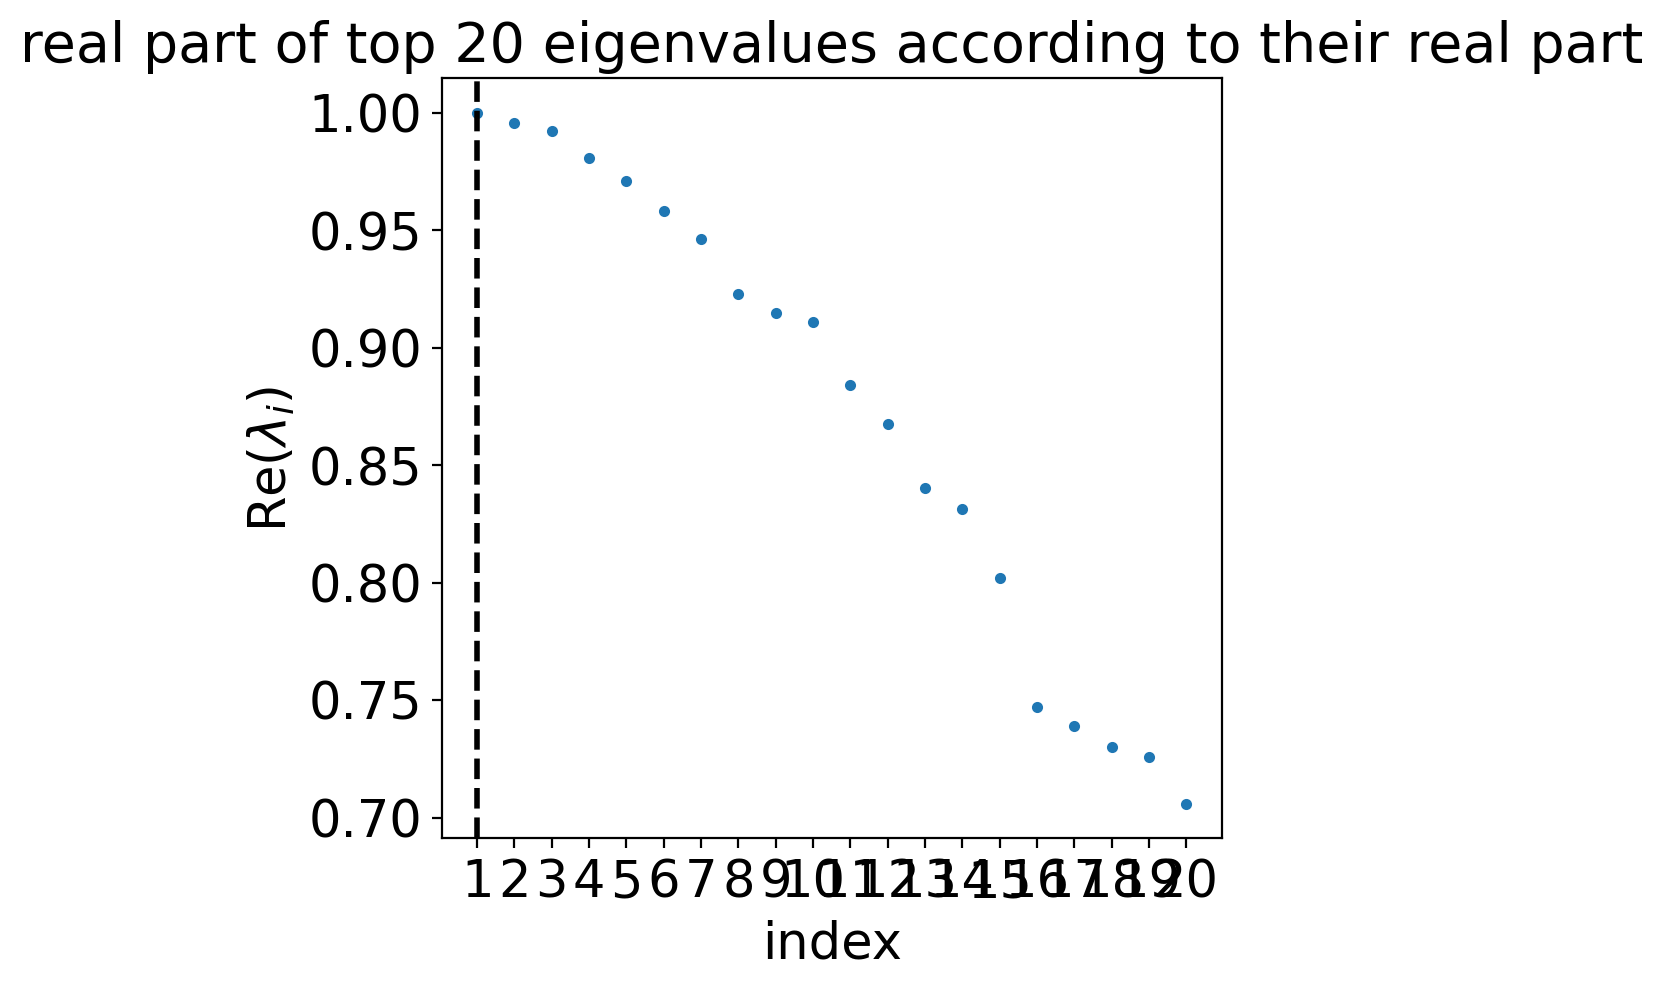

In [15]:
g.compute_schur()
g.plot_spectrum(real_only=True)

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp

saving figure to file /cluster/project/treutlein/USERS/mlange/github/moslin_analysis_3/figures/packer_c_elegans/umap_macrostates_OT.pdf


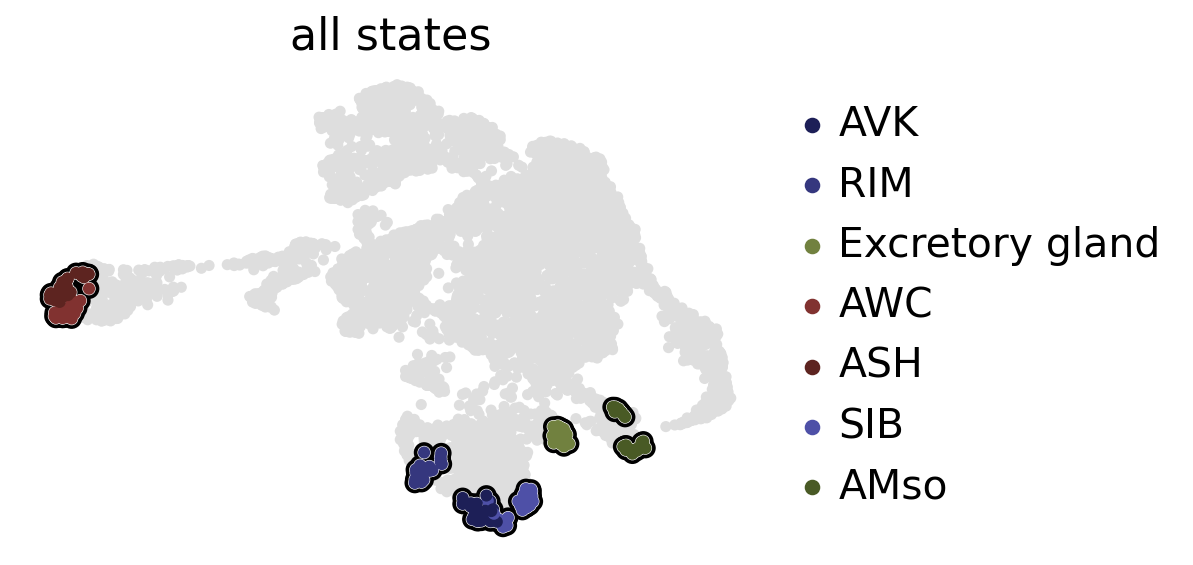

In [16]:
g.compute_macrostates(n_states=7, cluster_key="clusters")

fig_kwargs = {"legend_loc": "right", "s": 100, "which": "all"}
if save_figure:
    fig_kwargs["save"] = f"umap_macrostates_{METHOD}.pdf"

g.plot_macrostates(**fig_kwargs)

Define the order of these macrostates

In [17]:
# create a lookup table to link coarse clusters to clusters
df = (adata.obs.groupby(["clusters", "coarse_clusters"]).size() > 0).unstack()
lookup = {state: list(df.loc[df[state]].index) for state in adata.obs["coarse_clusters"].cat.categories}

# use the lookup to get an ordered list of states
ordered_clusters = list(chain(*[clusters for clusters in lookup.values()]))

# carry this over to macrostates
macrostates = [state for state in ordered_clusters if state in g.macrostates.cat.categories]
macrostates

['ASH', 'AWC', 'AVK', 'RIM', 'SIB', 'AMso', 'Excretory_gland']

Re-order macrostates accordingly. 

In [18]:
g._macrostates = StatesHolder(
    assignment=g._macrostates.assignment.cat.reorder_categories(macrostates),
    probs=None,
    memberships=g._macrostates.memberships[macrostates],
    colors=g._macrostates.memberships[macrostates].colors,
)

In [19]:
macrostate_time = mu.ul.get_state_time(adata, g, states="macrostates", obs_col="time_point")
macrostate_time

{'ASH': 462.0,
 'AWC': 480.0,
 'AVK': 494.0,
 'RIM': 482.0,
 'SIB': 480.0,
 'AMso': 452.0,
 'Excretory_gland': 490.0}

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/cellrank/_utils/_utils.py:851: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(path, bbox_inches="tight", transparent=True)
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


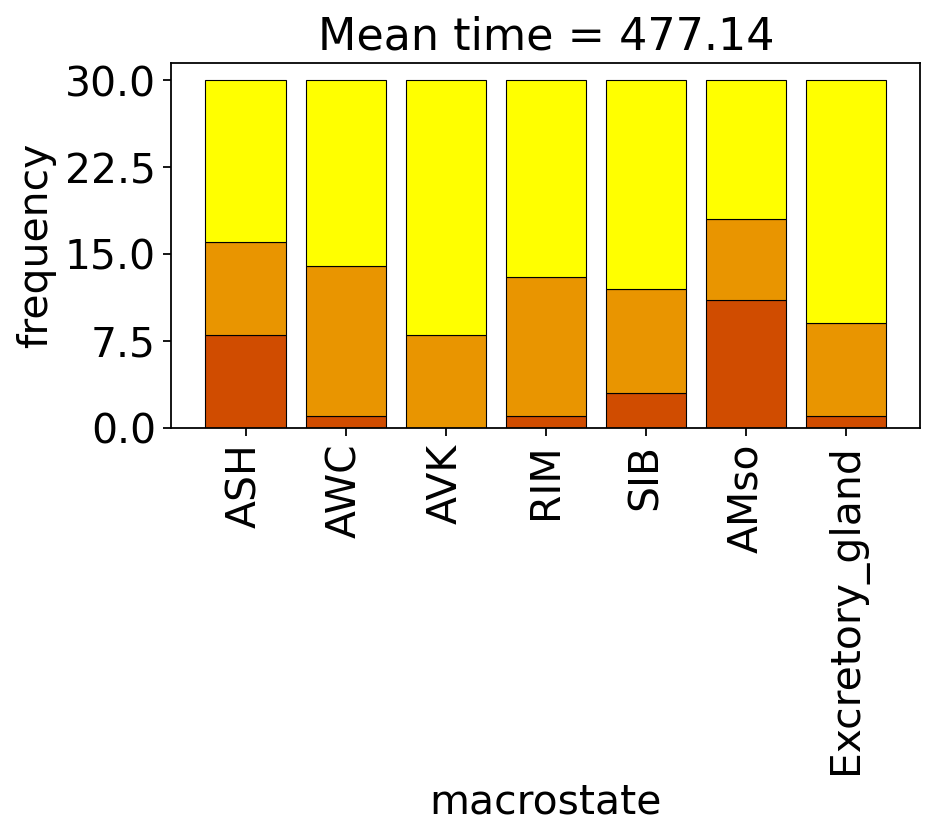

In [20]:
fig_kwargs = {
    "key": "time_point",
    "labelrot": 90,
    "figsize": (6, 3),
    "legend_loc": None,
    "title": f"Mean time = {np.mean(list(macrostate_time.values())):.2f}",
}

if save_figure:
    fig_kwargs["save"] = f"bar_time_point_{METHOD}.pdf"

g.plot_macrostate_composition(
    **fig_kwargs,
)

Look into macrostate purity

In [22]:
macrostate_purity = mu.ul.get_state_purity(adata, g, states="macrostates", obs_col="clusters")
macrostate_purity

{'ASH': 1.0,
 'AWC': 1.0,
 'AVK': 1.0,
 'RIM': 1.0,
 'SIB': 0.8,
 'AMso': 1.0,
 'Excretory_gland': 1.0}

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/cellrank/_utils/_utils.py:851: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(path, bbox_inches="tight", transparent=True)
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


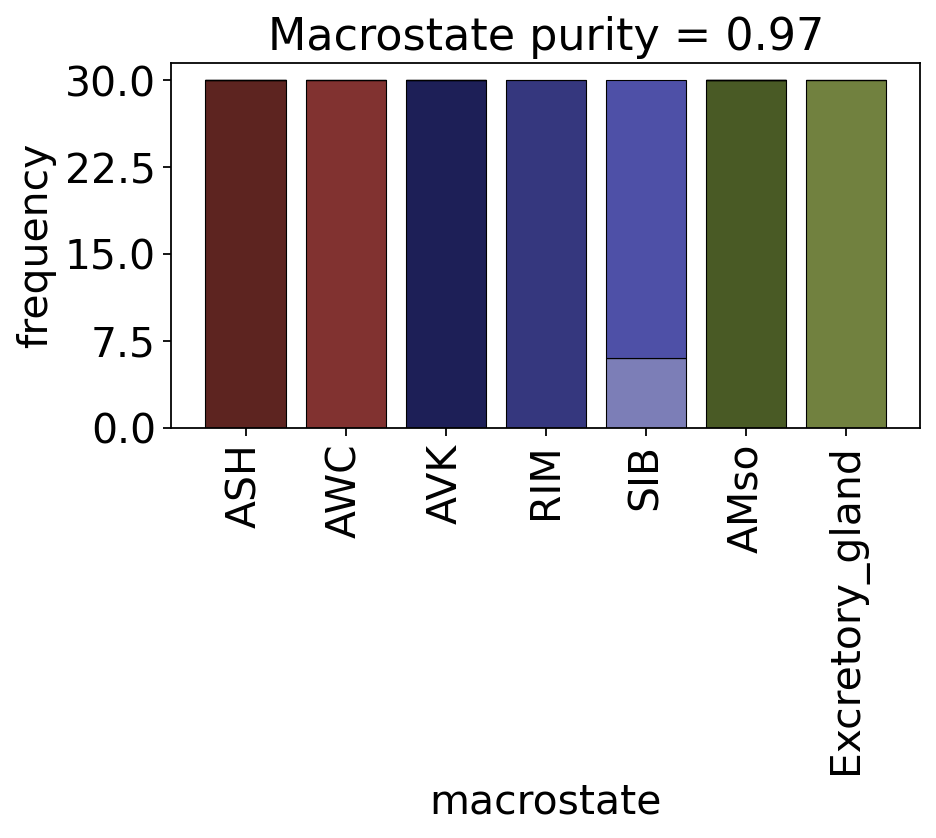

In [23]:
fig_kwargs = {
    "key": "clusters",
    "labelrot": 90,
    "figsize": (6, 3),
    "legend_loc": None,
    "title": f"Macrostate purity = {np.mean(list(macrostate_purity.values())):.2f}",
}

if save_figure:
    fig_kwargs["save"] = f"bar_clusters_{METHOD}.pdf"

g.plot_macrostate_composition(**fig_kwargs)

### Compute fate probabilities towards all terminal states

In [24]:
g.set_terminal_states()

GPCCA[kernel=(0.9 * RealTimeKernel[n=6476] + 0.1 * ConnectivityKernel[n=6476]), initial_states=None, terminal_states=['AMso', 'ASH', 'AVK', 'AWC', 'Excretory_gland', 'RIM', 'SIB']]

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp

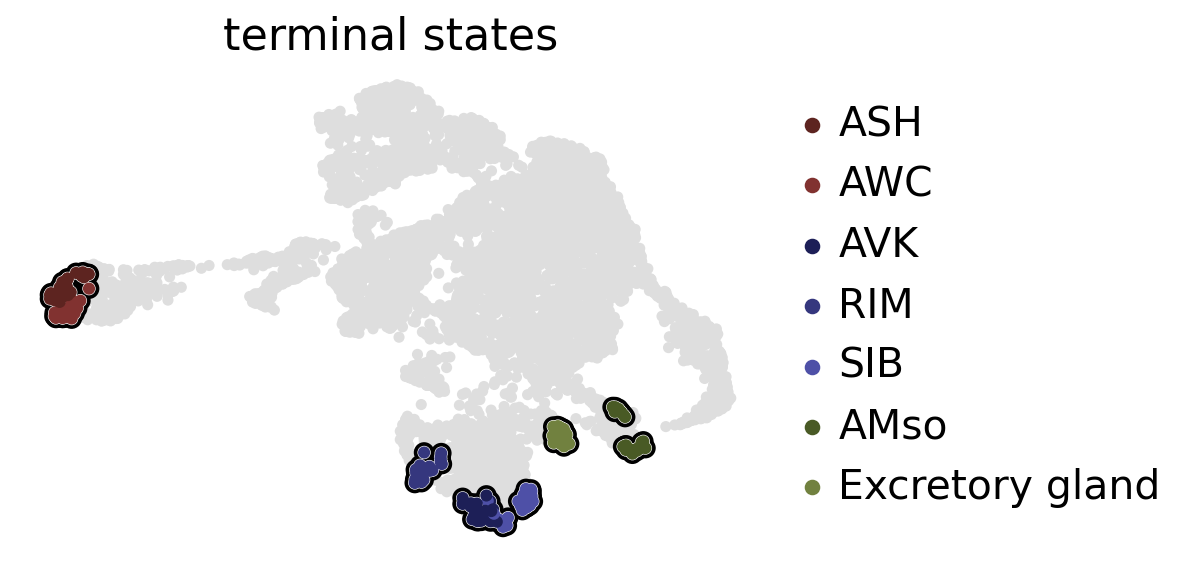

In [25]:
g.plot_macrostates(legend_loc="right", s=100, which="terminal")

100%|██████████| 7/7 [00:02<00:00,  2.83/s]
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


saving figure to file /cluster/project/treutlein/USERS/mlange/github/moslin_analysis_3/figures/packer_c_elegans/umap_all_fate_probs_OT.pdf


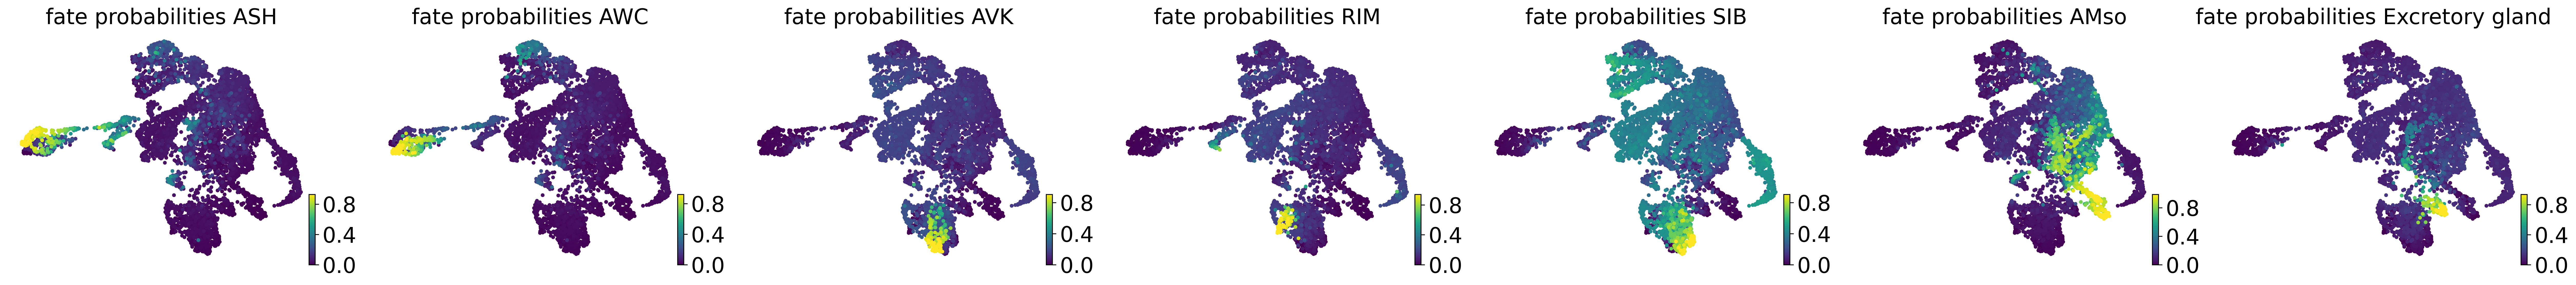

In [26]:
g.compute_fate_probabilities()

fig_kwargs = {}
if save_figure:
    fig_kwargs["save"] = f"umap_all_fate_probs_{METHOD}.pdf"

g.plot_fate_probabilities(same_plot=False, s=50, dpi=150, **fig_kwargs)

### Compute fate probabilities towards aggregated terminal states

This is a bit awkward in CellRank at the moment, but will be simplified in a future release. 

In [27]:
# Extract the cell indices for each group of cells. Use the lookup dict from above.
state_dict = {state: list(g.macrostates[g.macrostates.isin(lookup[state])].index) for state in KEY_STATE_COLORS.keys()}

# Manually set these to be terminal
g.set_terminal_states(
    states=state_dict,
    cluster_key="coarse_clusters",
)

GPCCA[kernel=(0.9 * RealTimeKernel[n=6476] + 0.1 * ConnectivityKernel[n=6476]), initial_states=None, terminal_states=['Ciliated neuron', 'Glia and excretory', 'Non-ciliated neuron']]

Again, re-order these and assign colors. 

In [28]:
g._term_states = StatesHolder(
    assignment=g._term_states.assignment.cat.reorder_categories(KEY_STATE_COLORS.keys()),
    probs=None,
    memberships=None,
    colors=KEY_STATE_COLORS.values(),
)

# also re-order in AnnData
adata.obs["term_states_fwd"] = adata.obs["term_states_fwd"].cat.reorder_categories(KEY_STATE_COLORS.keys())

# assign colors in AnnData as well
adata.uns["term_states_fwd_colors"] = [KEY_STATE_COLORS[state] for state in adata.obs["term_states_fwd"].cat.categories]

Plot the resulting aggregates terminal states

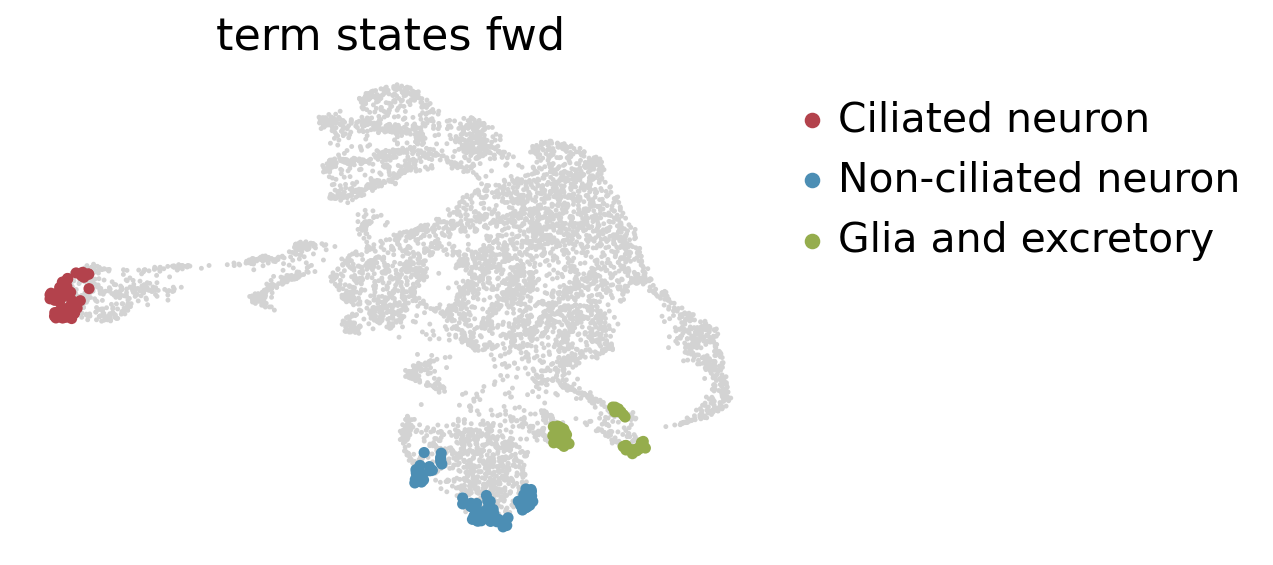

In [29]:
scv.pl.scatter(adata, c="term_states_fwd", s=100)

This combines the top 30 cells for each terminal state to represent the aggregated states. 

100%|██████████| 3/3 [00:01<00:00,  1.56/s]
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


saving figure to file /cluster/project/treutlein/USERS/mlange/github/moslin_analysis_3/figures/packer_c_elegans/umap_aggregated_fate_probabilities_OT.pdf


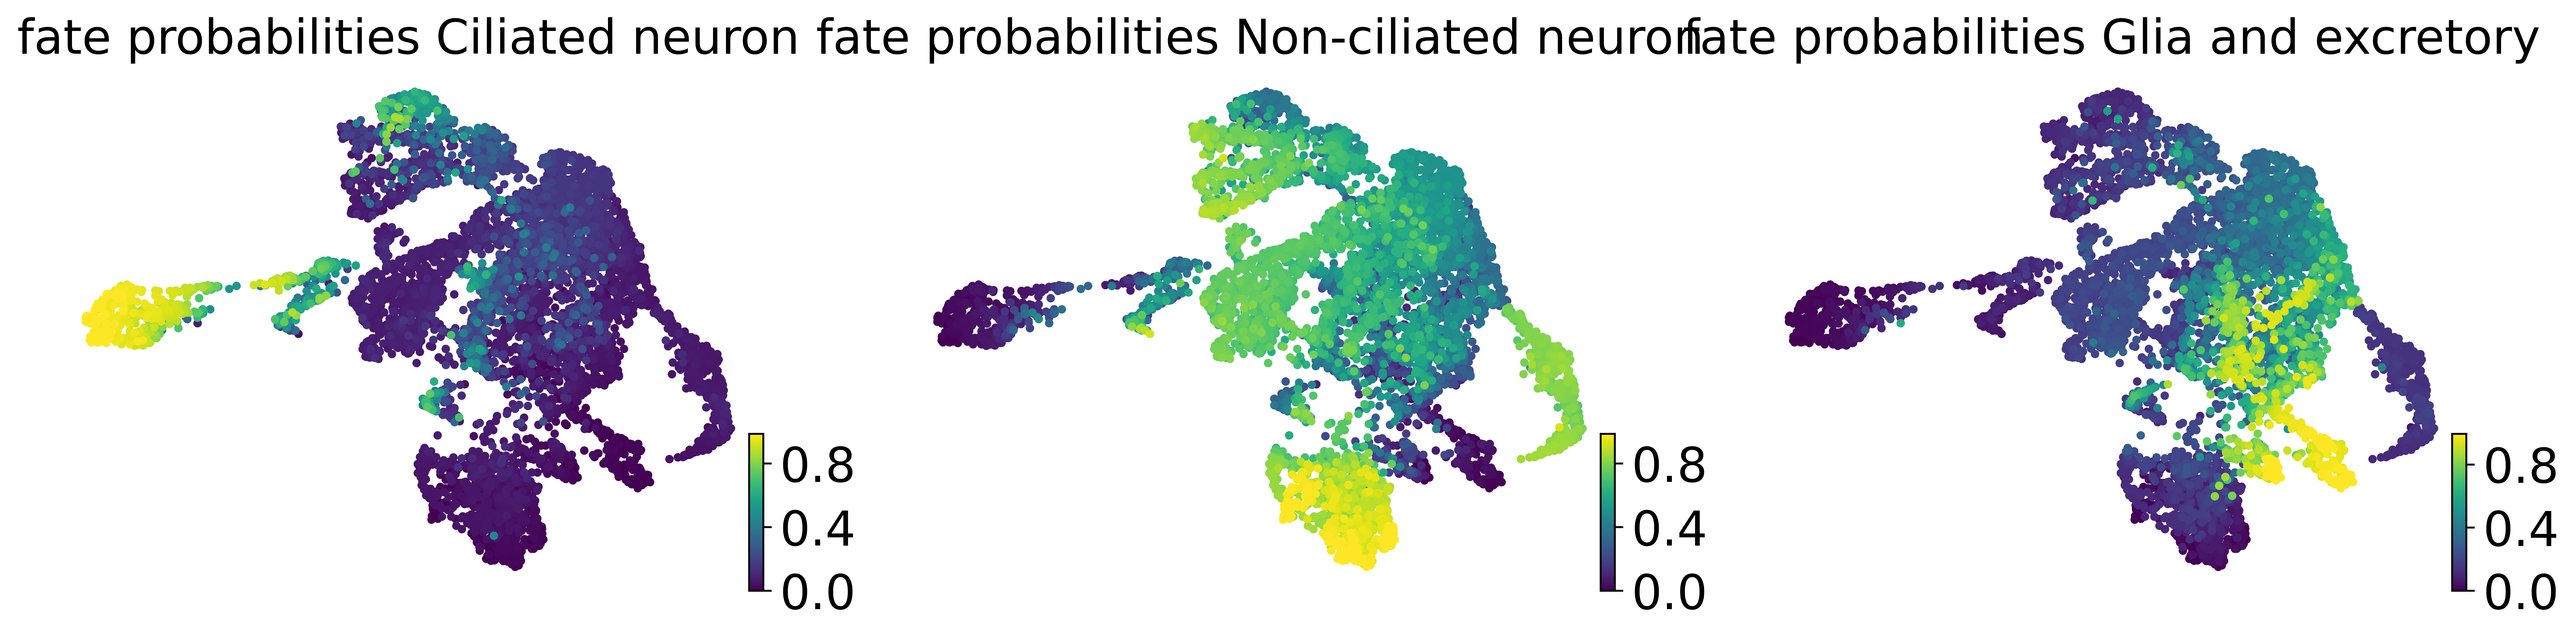

In [30]:
g.compute_fate_probabilities()

fig_kwargs = {"same_plot": False, "dpi": DPI_SAVE, "s": 50}
if save_figure:
    fig_kwargs["save"] = f"umap_aggregated_fate_probabilities_{METHOD}.pdf"

g.plot_fate_probabilities(**fig_kwargs)

### Visualize aggregated fate probabilities

Visualize the fate bias within progenitor cells

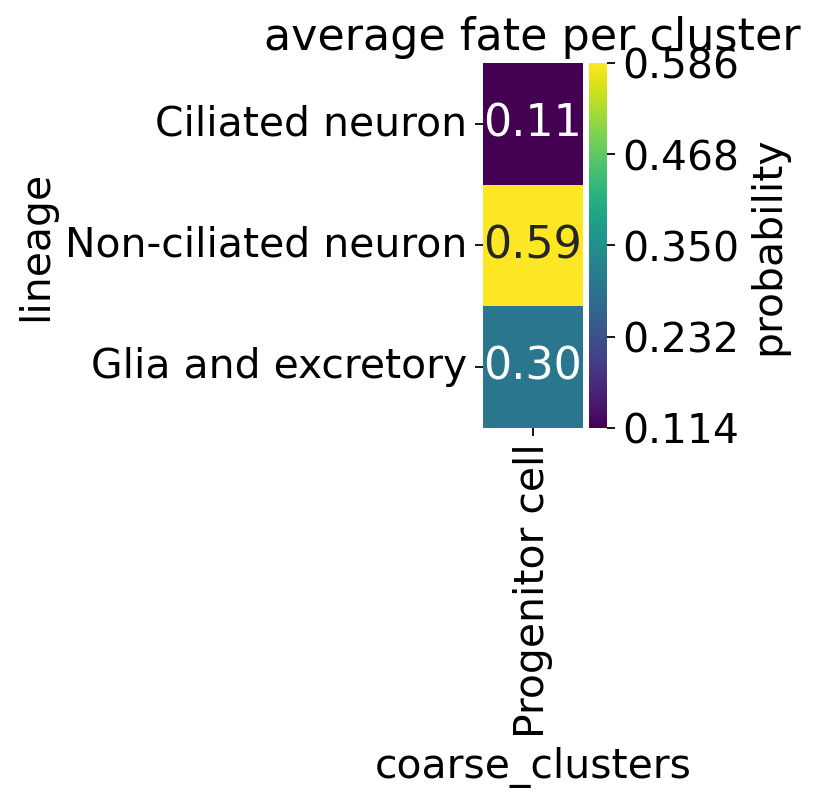

In [31]:
figure_kwargs = {
    "cluster_key": "coarse_clusters",
    "mode": "heatmap",
    "clusters": ["Progenitor cell"],
    "figsize": (1, 3),
}
if save_figure:
    figure_kwargs["save"] = f"heatmap_progenitor_bias_{METHOD}.pdf"
cr.pl.aggregate_fate_probabilities(adata, **figure_kwargs)

Visualize fate probabilities as violin plots, grouped by preterminal state

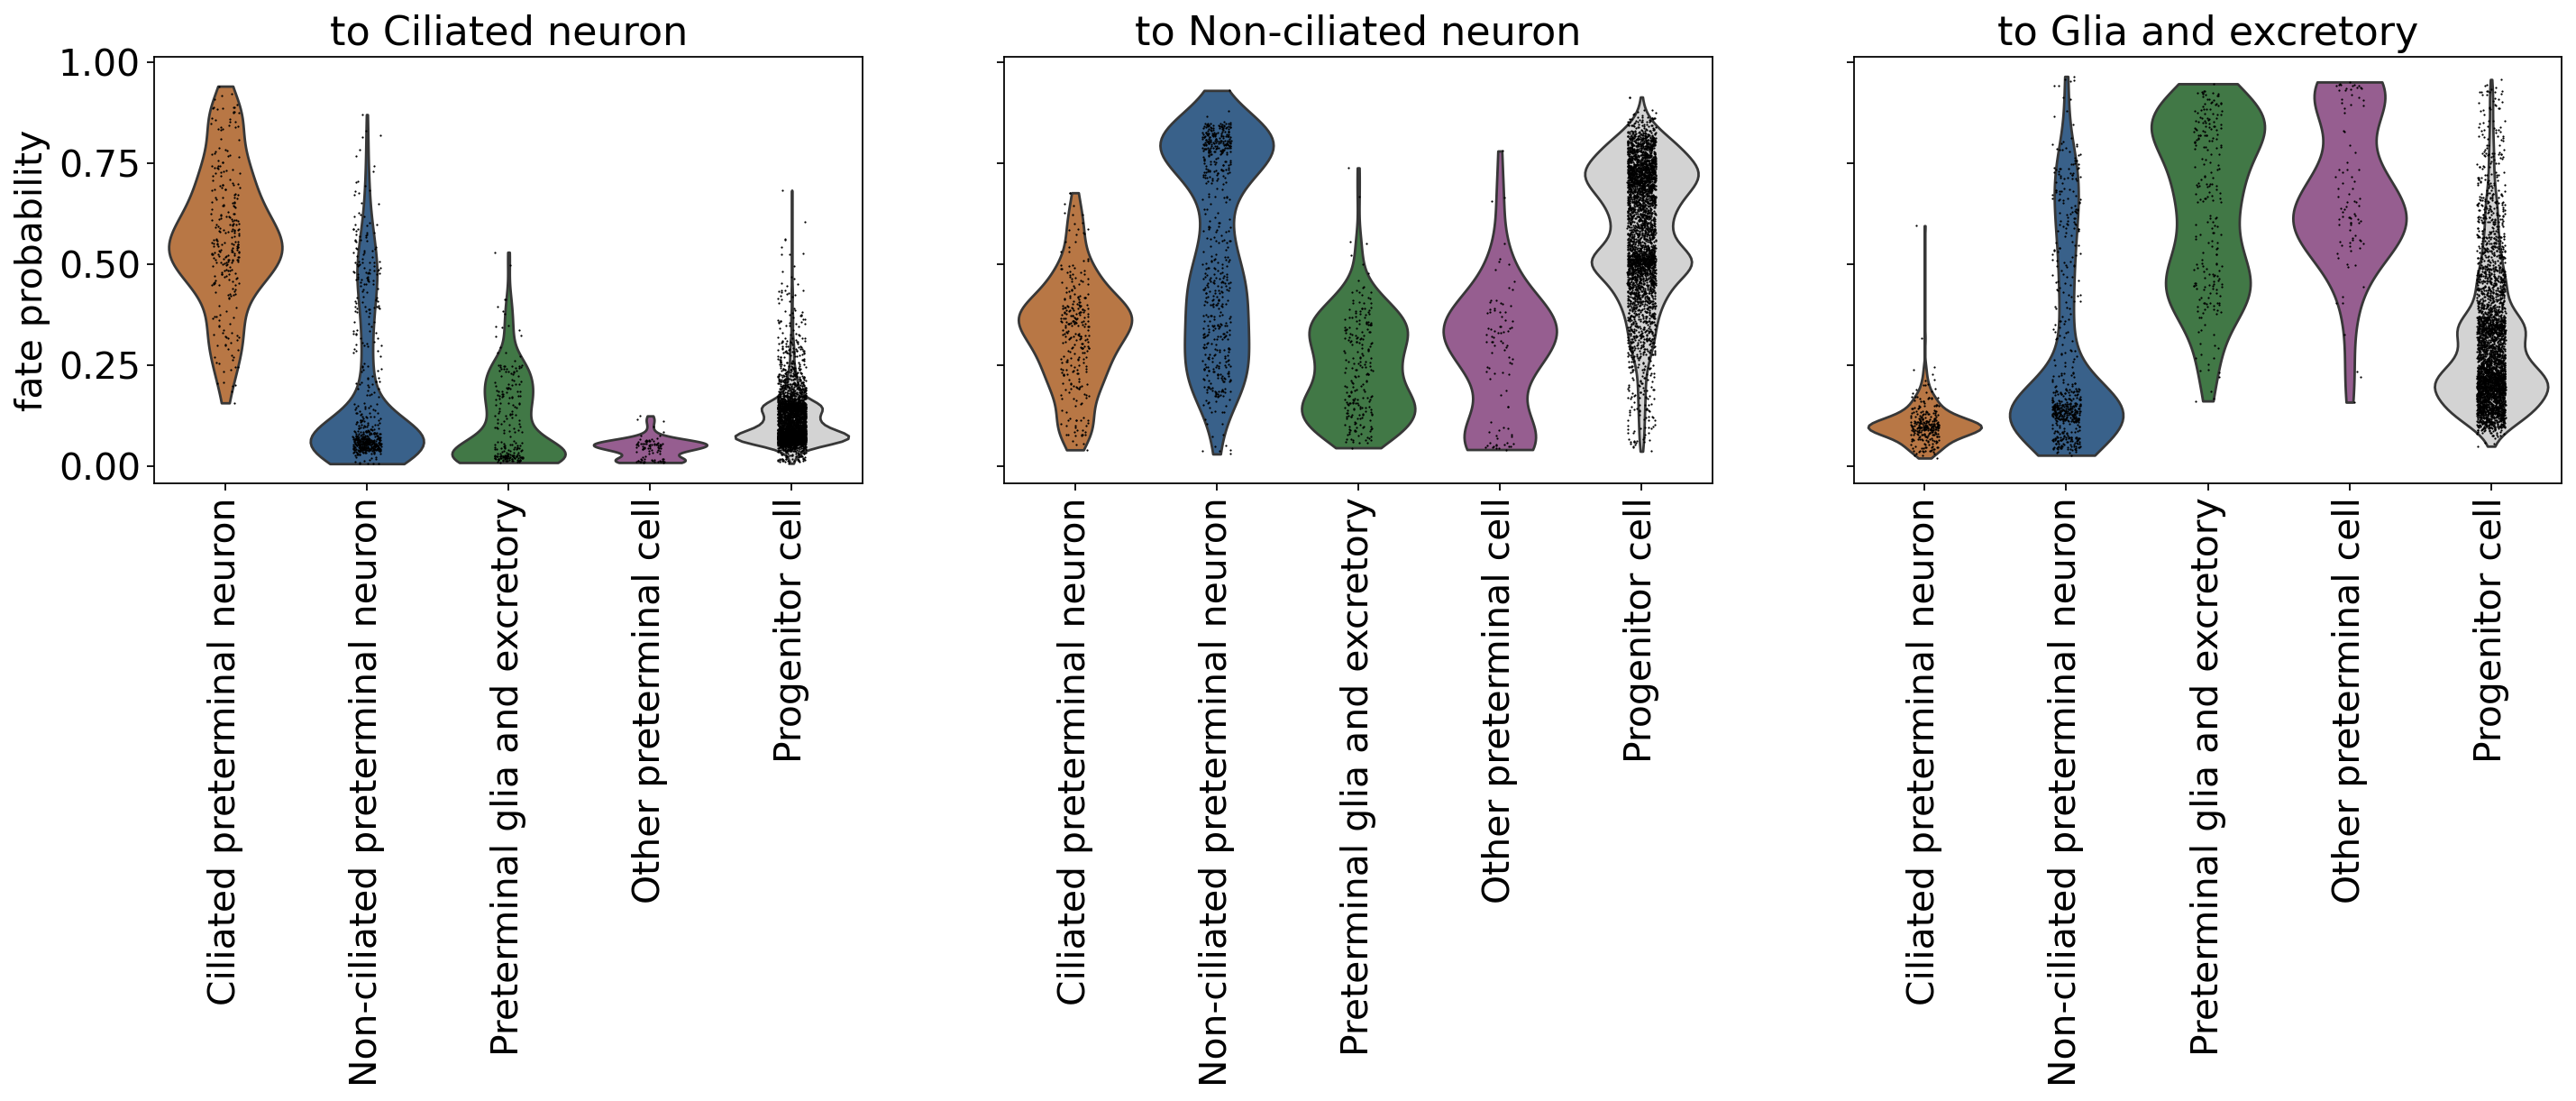

In [32]:
# subset to the interesting categories (i.e. not the final cell types)
progenitor_clusters = [
    "Ciliated preterminal neuron",
    "Non-ciliated preterminal neuron",
    "Preterminal glia and excretory",
    "Other preterminal cell",
    "Progenitor cell",
]

# define a corresponding mask
mask = np.in1d(adata.obs["coarse_clusters"], progenitor_clusters)

# and plot
fig_kwargs = {"mode": "violin", "cluster_key": "coarse_clusters", "clusters": progenitor_clusters}
if save_figure:
    fig_kwargs["save"] = f"violin_aggregated_fate_probabilities_{METHOD}.pdf"

cr.pl.aggregate_fate_probabilities(adata[mask], sharey=True, **fig_kwargs)

Show this in a more aggregated form using heatmaps over just the average

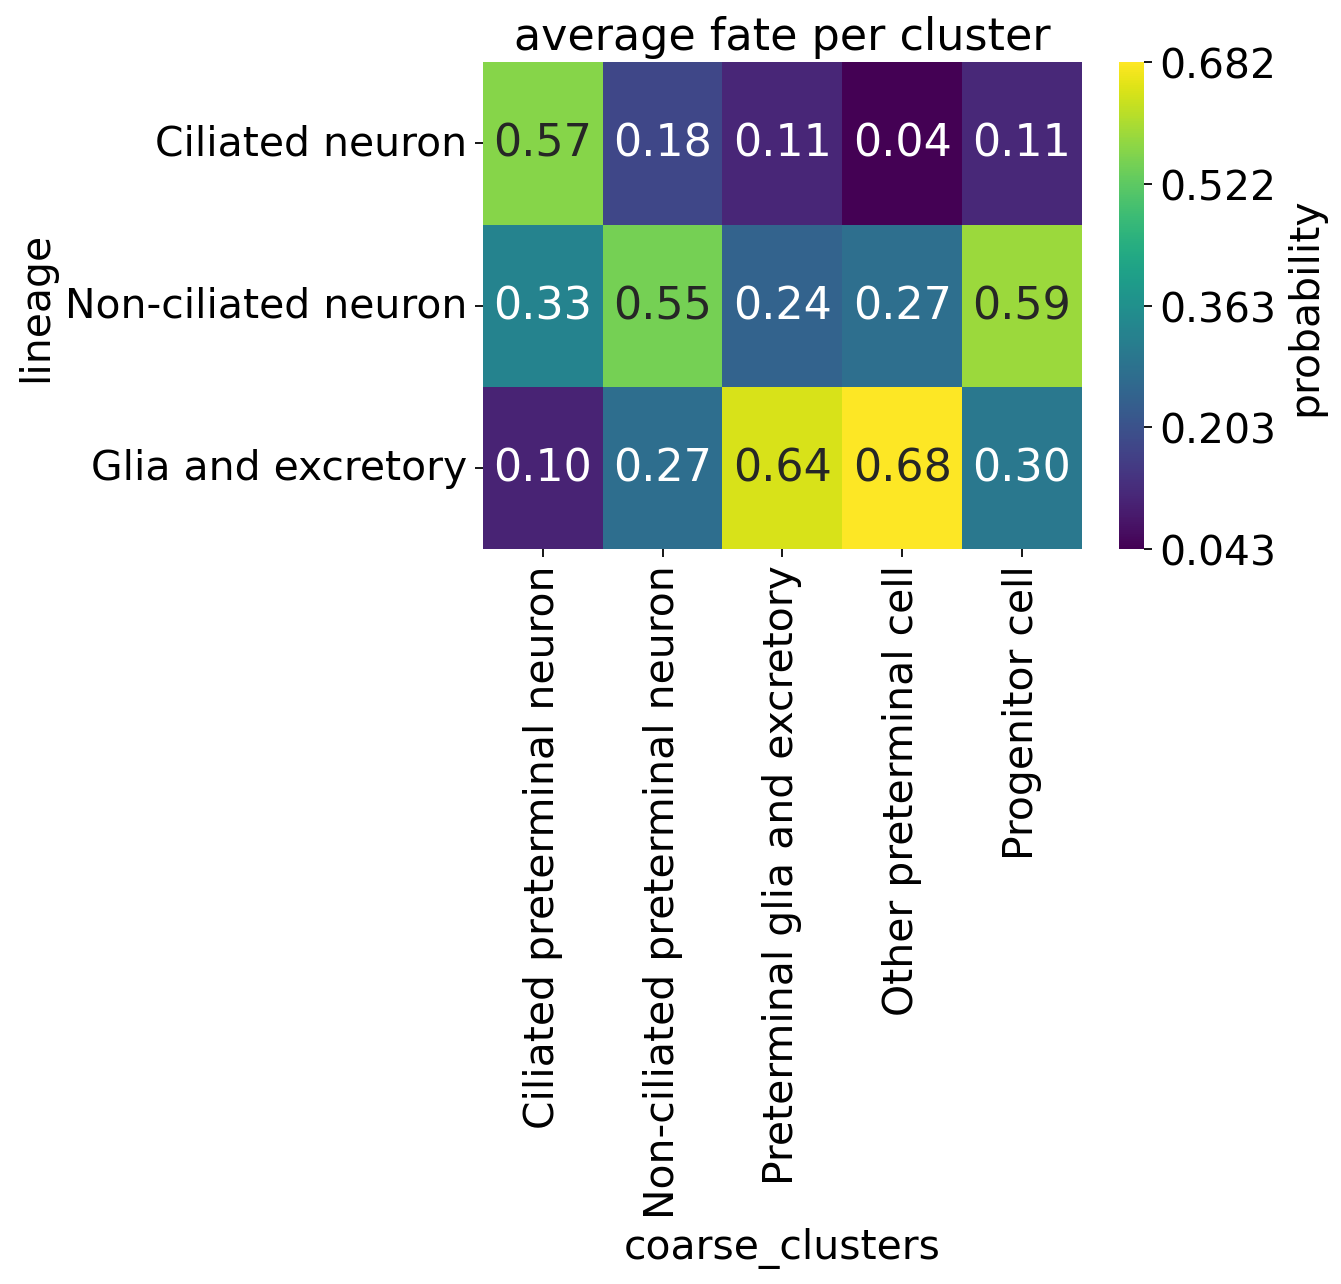

In [33]:
# and plot
fig_kwargs = {"mode": "heatmap", "cluster_key": "coarse_clusters", "clusters": progenitor_clusters}

if save_figure:
    fig_kwargs["save"] = f"heatmap_aggregated_fate_probabilities_{METHOD}.pdf"

cr.pl.aggregate_fate_probabilities(adata, **fig_kwargs)